# Lab 8 Report: 
## FINAL PROJECT STRATEGIC PLANNING

### Lab 8 Instruction: https://canvas.uw.edu/courses/1548925/files/92225287?wrap=1

### Team Members: Ahad

### Dataset for your project: CCSN Gravitational Wave Detection

#### Feel free to delete or modify pre-written markdown cells below the line

------------------

In [29]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import IPython
import tqdm

from scipy.io.wavfile import write

print("test")

test


In [30]:
sns.set(style = 'white', font_scale = 1.5)

## Understanding the Data

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
import h5py
import pandas as pd

# opening file for reading 

# NOTE: I will be using the 2.5 GB file that was supposed to be used for just testing and validation for everything
# the actual training data was too large (almost 20 GB) and was thus incredibly slow to run through
# I will be splitting this dataset into everything: training, test, and validation sets

file_path = 'drive/MyDrive/Internship/PHYS 427 Lab 8 - CCSN Gravitational Waves Detection/CCSN_Pan_SNR_Free_Test_Validation.h5'
hdf = h5py.File(file_path)
ls = list(hdf.keys())
print("List of datasets in this file: \n", ls)

# assigning each dataset to relevant variables
    # no rotation
signal_nr = hdf['Model_NR']['Hp']
    # fast rotation
signal_fr = hdf['Model_FR']['Hp']
    # slow rotation
signal_sr = hdf['Model_SR']['Hp']
    # raw noise data
noise = hdf['Noise']['Strain']

List of datasets in this file: 
 ['Dis', 'Model_FR', 'Model_NR', 'Model_SR', 'Noise']


In [33]:
# converting into numpy array
signal_nr = np.array(signal_nr)
signal_fr = np.array(signal_fr)
signal_sr = np.array(signal_sr)
#noise = np.array(noise)

# printing out shapes
print("Shape of no rotation signal: \n", signal_nr.shape)
print("\n\nShape of fast rotation signal: \n", signal_fr.shape)
print("\n\nShape of slow rotation signal: \n", signal_sr.shape)
print("\n\nShape of noise: \n", noise.shape)

Shape of no rotation signal: 
 (6250, 8192)


Shape of fast rotation signal: 
 (6250, 8192)


Shape of slow rotation signal: 
 (6250, 8192)


Shape of noise: 
 (18750, 8192)


In [34]:
# split dataset into testing and training
# training to testing ratio: 50000/6250 = 8
# therefore take first 781 of each signal set (size 6250) 
signal_nr_test = signal_nr[:781]
signal_fr_test = signal_fr[:781]
signal_sr_test = signal_sr[:781]

# take remaining as training set
signal_nr_train = signal_nr[781:]
signal_fr_train = signal_fr[781:]
signal_sr_train = signal_sr[781:]

# now taking first 2344 points for noise testing set
noise_test = noise[:2343]
# ... and remaining points for training set
noise_train = noise[2343:]

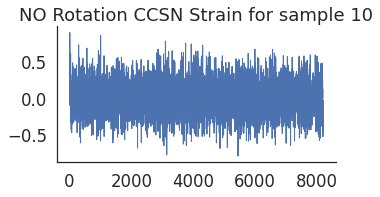

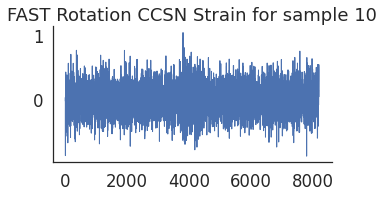

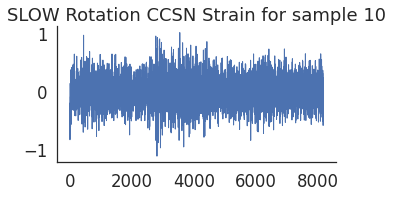

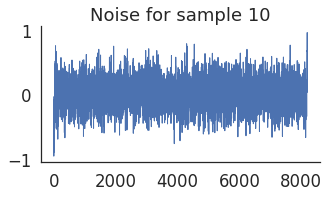

In [35]:
# graphing each dataset for training data

# sample number for each dataset (6250-781 total)
sample = 10

# nr
plt.figure(figsize = (5, 2.5))
plt.plot(signal_nr_train[sample], linewidth = 1)
plt.title('NO Rotation CCSN Strain for sample '+str(sample))
sns.despine()

# fr
plt.figure(figsize = (5, 2.5))
plt.title('FAST Rotation CCSN Strain for sample '+str(sample))
plt.plot(signal_fr_train[sample], linewidth = 1)
sns.despine()

#sr
plt.figure(figsize = (5, 2.5))
plt.title('SLOW Rotation CCSN Strain for sample '+str(sample))
plt.plot(signal_sr_train[sample], linewidth = 1)
sns.despine()

# noise
plt.figure(figsize = (5, 2.5))
plt.title('Noise for sample '+str(sample))
plt.plot(noise_train[sample], linewidth = 1)
sns.despine()

In [36]:
# Creating signal array for training (1)
signals_train = np.concatenate((signal_nr_train, signal_sr_train, signal_fr_train), axis=0)
signals_train.shape

(16407, 8192)

In [37]:
# Creating signal array for testing (1)
signals_test = np.concatenate((signal_nr_test, signal_sr_test, signal_fr_test), axis=0)
signals_test.shape

(2343, 8192)

In [38]:
# training noise array (0)
noise_train.shape

(16407, 8192)

In [39]:
# testing noise array (0)
noise_test.shape

(2343, 8192)

In [40]:
# shuffling signals and noise to create feature and target array

def shuffle(a, b):
    indexes = np.random.permutation(len(a) + len(b))
    features = []
    targets = []
    
    for i in indexes:
        if i < len(a):
            features.append(a[i])
            # targets assigned a 0 
            targets.append(0)
        else:
            features.append(b[i-len(a)])
            # targets assigned a 1
            targets.append(1)
            
    return features, targets

In [41]:
# define training features and training targets
features, targets = shuffle(noise_train, signals_train)

features_train = np.array(features)
targets_train = np.array(targets)

features_train.shape, targets_train.shape

((32814, 8192), (32814,))

In [42]:
# define testing features and testing targets
features, targets = shuffle(noise_test, signals_test)

features_test = np.array(features)
targets_test = np.array(targets)

features_test.shape, targets_test.shape

((4686, 8192), (4686,))

In [43]:
# create validation set by taking first 10% of training data (about first 3281)

features_validation = features_train[:3281]
targets_validation = targets_train[:3281]

# take remaining data for training set

features_train = features_train[3281:]
targets_train = targets_train[3281:]

In [44]:
targets_train = targets_train.reshape(29533, 1)
targets_validation = targets_validation.reshape(3281, 1)
targets_test = targets_test.reshape(4686, 1)
'''
# Reshape to conform to PyTorch (sample size (N), sequence length, # of features) 
features_train = features_train.reshape((features_train.shape[0], -1, 1))
targets_train = targets_train.reshape((targets_train.shape[0], -1, 1))

features_test = features_test.reshape((features_test.shape[0], -1, 1))
targets_test = targets_test.reshape((targets_test.shape[0], -1, 1))

features_validation = features_validation.reshape((features_validation.shape[0], -1, 1))
targets_validation = targets_validation.reshape((targets_validation.shape[0], -1, 1))
'''

'''
# Reshape train/validation/test sets to conform to PyTorch's (N, Channels, Height, Width) standard for CNNs

features_train = np.reshape(features_train, (29533, 1, 1, 8192))
features_validation = np.reshape(features_validation, (3281, 1, 1, 8192))
features_test = np.reshape(features_test, (4686, 1, 1, 8192))
'''

"\n# Reshape train/validation/test sets to conform to PyTorch's (N, Channels, Height, Width) standard for CNNs\n\nfeatures_train = np.reshape(features_train, (29533, 1, 1, 8192))\nfeatures_validation = np.reshape(features_validation, (3281, 1, 1, 8192))\nfeatures_test = np.reshape(features_test, (4686, 1, 1, 8192))\n"

In [45]:
print("Training features and targets sets shapes:\n" + str((features_train.shape, targets_train.shape)))

print("\nTesting feautures and targets sets shape:\n" + str((features_test.shape, targets_test.shape)))

print("\nValidation features and targets sets shape:\n" + str((features_validation.shape, targets_validation.shape)))

Training features and targets sets shapes:
((29533, 8192), (29533, 1))

Testing feautures and targets sets shape:
((4686, 8192), (4686, 1))

Validation features and targets sets shape:
((3281, 8192), (3281, 1))


## Understanding the Task

This task first necessitates a Fully Connected Network binary classification model with a softmax output of 0, designating noise, and 1, designating a CCSN gravitational wave.

The task essentially to identify each sample, from all signal parameters (No Rotation, Slow Rotation, and Fast Rotation), as containing a CCSN (1) or being strictly noise (0). It is therefore a binary classification problem.

I can also compare the performance of this model for different rotations. Perhaps a particular rotation is easier for the model, and contains more CCSNs. Or perhaps the model is generalizing to different rotations without an issue.

## Developing an initial plan for your project

I will be using a FCN binary classification model when defining my class model. 
- input dimensions: 8192
- 3 neural network layers
- batchsize: 4219 (7 batches)

In [46]:
class BinaryClassification(torch.nn.Module):
    
    def __init__(self, input_dim, output_dim, hidden1_dim, hidden2_dim):
        
        super(BinaryClassification, self).__init__()
        
        # we will have 5 neural network layers
        
        self.layer1 = torch.nn.Linear(input_dim, hidden1_dim)
        self.layer2 = torch.nn.Linear(hidden1_dim, hidden2_dim)
        self.layer3 = torch.nn.Linear(hidden2_dim, output_dim)

        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(p=0.1) # dropouts neurons with probability of neuron dropout being 25%
        self.bn1 = torch.nn.BatchNorm1d(hidden1_dim)
        self.bn2 = torch.nn.BatchNorm1d(hidden2_dim)
        ''' other stuff
        torch.nn.init.kaiming_uniform_(self.layer3.weight)
        '''
        
    def forward(self, x):
        
        x = self.relu(self.layer1(x))
        x = self.bn1(x)
        x = self.relu(self.layer2(x))
        x = self.bn2(x)
        x = self.dropout(x)
        x = self.layer3(x)
        
        return x

'''
class BinaryClassificationLSTM(torch.nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        
        super(BinaryClassificationLSTM, self).__init__()
        
        # using LSTM cell with batch_first = True, thus using (sample_size, sequence_length, # of features) format
        # bidirectional = False, so only forward context is taken
        self.lstm = torch.nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                                  num_layers=num_layers,
                                  batch_first=True,
                                  bidirectional=False)
        
        # decoder layer to take in LSTM hidden states and output a single number (denoised value at time t)
        self.decoder = torch.nn.Linear(hidden_size, output_size)
        
        # uses Tanh activation to squeeze the decoder output between -1 and 1
        # (data consists of sinusodial between -1 and 1)
        self.output_activation = torch.nn.Tanh()
        
    def forward(self, input_seq, hidden_state):
        
        # feed the LSTM cell with input sequence and initial hidden state
        pred, hidden = self.lstm(input_seq, hidden_state)
        
        # feed the output of LSTM (pred) to decoder layer, followed by taking the Tanh activation
        denoised_seq = self.output_activation(self.decoder(pred))
        
        return denoised_seq

'''

class BinaryClassificationCNNModel(torch.nn.Module):
    
    def __init__(self):
        super(BinaryClassificationCNNModel, self).__init__()
        
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2)
        )
        
        self.fc1 = torch.nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = torch.nn.Dropout(p=0.25)
        self.fc2 = torch.nn.Linear(in_features=600, out_features=120)
        self.fc3 = torch.nn.Linear(in_features=120, out_features=1)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out



In [47]:
# fix the manual seed so that the model performance is reproducable
torch.manual_seed(55)

# initialize our neural network model with input and output dimensions

# subject to change
dim1 = 1024
dim2 = 8


model = BinaryClassification(input_dim = 8192, output_dim = 1, 
                             hidden1_dim = dim1, 
                             hidden2_dim = dim2)

#model = BinaryClassificationCNNModel()

#model = BinaryClassificationLSTM(input_size = 1, hidden_size = 30, num_layers = 1, output_size = 1)

# define learning rate and # of epochs
learning_rate = 0.001
epochs = 25
batchsize = 4219

# define supervised loss function and optimizer
loss_func = torch.nn.BCEWithLogitsLoss()
#loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

model

BinaryClassification(
  (layer1): Linear(in_features=8192, out_features=1024, bias=True)
  (layer2): Linear(in_features=1024, out_features=8, bias=True)
  (layer3): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (bn1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [48]:
# identify tracked values 
train_loss_list = []
validation_accuracy_list = np.zeros((epochs,))

# converting training set into torch tensors
features_train = torch.FloatTensor(features_train)
targets_train = torch.FloatTensor(targets_train)

# converting validation set into torch tensors
features_validation = torch.FloatTensor(features_validation)
targets_validation = torch.FloatTensor(targets_validation)

# converting testing set into torch tensors 
features_test = torch.FloatTensor(features_test)
targets_test = torch.FloatTensor(targets_test)


# splitting training set into batches sizes of 4219
train_batches_features = torch.split(features_train, batchsize)
train_batches_targets = torch.split(targets_train, batchsize)

batch_split_num = len(train_batches_features)
        
print(train_batches_features[0].shape)
print(train_batches_targets[0].shape)

torch.Size([4219, 8192])
torch.Size([4219, 1])


In [49]:
print(train_batches_features[1])

tensor([[ 0.1049, -0.3944, -0.4417,  ...,  0.0546, -0.1608, -0.0238],
        [ 0.0764,  0.0782, -0.1603,  ...,  0.1193,  0.1823, -0.0184],
        [-0.0604,  0.2844,  0.1055,  ...,  0.0588,  0.0576,  0.0298],
        ...,
        [ 0.0487, -0.6919, -0.7226,  ..., -0.0526, -0.0438, -0.0363],
        [-0.0188,  0.1516,  0.4674,  ..., -0.0468, -0.1285, -0.0067],
        [-0.0358, -0.0233, -0.0907,  ...,  0.6482,  0.7371,  0.0166]])


In [50]:
print(train_batches_targets[1])

tensor([[0.],
        [0.],
        [1.],
        ...,
        [1.],
        [0.],
        [1.]])


In [51]:
# Training loop ----------------------------------------------------------------------------------------
for epoch in tqdm.trange(epochs):
    
    for i in range(batch_split_num):
        #hidden_state = None
        train_outputs = model(train_batches_features[i])
        #print(train_outputs, train_batches_targets[i].shape)
        loss = loss_func(train_outputs, train_batches_targets[i])
        train_loss_list.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Compute validation accuracy ---------------------------------------------------------------------
    
    with torch.no_grad():
        
        validation_outputs = model(features_validation)
        correct = (torch.argmax(validation_outputs, dim=1) == targets_validation).type(torch.FloatTensor)
        validation_accuracy_list[epoch] = correct.mean()

100%|██████████| 25/25 [19:58<00:00, 47.96s/it]


'\nplt.subplot(2,1,2)\nplt.plot(validation_accuracy_list, linewidth=3, color="gold")\nplt.ylabel("validation accuracy")\nplt.xlabel("epochs")\nsns.despine()\n'

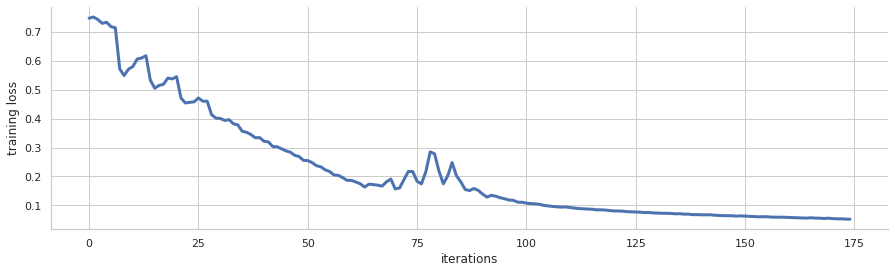

In [52]:
# visualizing training loss

sns.set(style = 'whitegrid', font_scale = 1)

plt.figure(figsize = (15,9))

plt.subplot(2,1,1)
plt.plot(train_loss_list, linewidth=3)
plt.ylabel("training loss")
plt.xlabel("iterations")
sns.despine()

'''
plt.subplot(2,1,2)
plt.plot(validation_accuracy_list, linewidth=3, color="gold")
plt.ylabel("validation accuracy")
plt.xlabel("epochs")
sns.despine()
'''

In [54]:
# compute testing accuracy 

with torch.no_grad():
    
    y_pred_test = model(features_test)
    
    correct = (torch.argmax(y_pred_test, dim=1) == targets_test).type(torch.FloatTensor)
    
    print("Testing Accuracy: " + str(correct.mean().numpy()*100) + '%')


Testing Accuracy: 84.9%


no CCSN gravitational wave
tensor([0.])


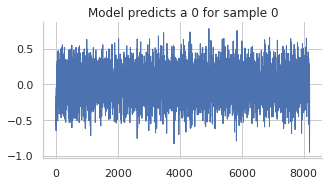

In [61]:
# Predictions

sample = 0

with torch.no_grad():
    predict = model(features_test)

prediction = torch.argmax(predict[sample])

if prediction.item()== 0:
    print("no CCSN gravitational wave")
else:
    print("there is indeed a CCSN gravitational wave in this sample")
    
targets_test[sample]

# nr
plt.figure(figsize = (5, 2.5))
plt.plot(features_test[sample], linewidth = 1)
plt.title('Model predicts a '+ str(prediction.item()) + " for sample " + str(sample))
sns.despine()



There is indeed a CCSN gravitational wave in this sample
tensor([1.])


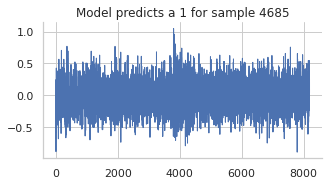

In [69]:
sample = 4685

with torch.no_grad():
    predict = model(features_test)

prediction = torch.argmax(predict[sample])

if prediction.item()== 0:
    print("no CCSN gravitational wave")
else:
    print("there is indeed a CCSN gravitational wave in this sample")

print(targets_test[sample])


# nr
plt.figure(figsize = (5, 2.5))
plt.plot(features_test[sample], linewidth = 1)
plt.title('Model predicts a 1'+ str(prediction.item()) + " for sample " + str(sample))
sns.despine()
